In [1]:
#Importo las librerías necesarias
import torch
from torchvision import transforms
from PIL import Image
from torchvision import models
from torch import nn

In [342]:
#Configuro el dispositivo
device="cuda" if torch.cuda.is_available() else "cpu"

# Defino la función para cargar las imágenes (estilo y contenido)

In [343]:
def load_image(path_img,size_img=(256)):
  #Obtengo la imagen (inicialmente, object PIL)
  imagen_pil=Image.open(path_img)

  #Defino el preprocesamiento que se aplicará a la imagen
  preprocess=transforms.Compose([
      transforms.Resize((size_img,size_img)), #Primero, realizo el resize de la imagen
      transforms.ToTensor() #Luego, convierto la imagen PIL a tensor
  ])

  #Obtengo la imagen resultante
  imagen_resultante=preprocess(imagen_pil)

  return imagen_resultante.unsqueeze(0).to(device) #Añado la dimensión del batch

# Defino las loss functions: content style y loss style

## Content Loss:

In [344]:
class ContentLoss(nn.Module):
  #Inicializo el constructor
  def __init__(self,target_img):
    #Inicializo el constructor de la clase padre
    super().__init__()
    #Instancio la target image para calcular el loss de la imagen generada
    self.target_img=target_img.detach()

  #Ahora, calculo el loss
  def forward(self,generated_img):
    self.content_loss=nn.functional.mse_loss(generated_img,self.target_img)

    #Se retorna la misma imagen, ya que esa misma imagen es la que se tiene que pasar de capa en capa
    return generated_img

## Style Loss

In [345]:
#Defino la matriz de Gram
def gram_matrix(img):
  #Tomo cada una de las dimensiones para crear la matriz de gram
  batch_size,channels_size,h,w=img.shape

  #Ahora, realizo una redimensión
  matriz_fm=img.view(batch_size*channels_size,h*w)

  #Calculo la matriz de Gram (matriz*matriz_transpuesta)
  gram=torch.mm(matriz_fm,matriz_fm.t())

  return gram

In [346]:
class StyleLoss(nn.Module):
  #Defino el constructor (y defino en el constructor la imagen de estilo)
  def __init__(self,style_img):
    super().__init__()
    self.style_img=style_img.detach()

  def forward(self, generated_img):
    #En el forward pass del style loss, calculo la matriz de gram para ambas imágenes
    gram_style_img=gram_matrix(self.style_img) #Gram matrix de la imagen de estilo
    gram_generated_img=gram_matrix(generated_img) #Gram matrix de la imagen generada
    #print("gram_style_img:",gram_style_img.shape)
    #print("gram_generated_img:",gram_generated_img.shape)
    #Calculo el loss
    self.style_loss=nn.functional.mse_loss(gram_style_img,gram_generated_img)

    #Retorno la generated_img (la imagen que se tiene que ajustar) para que las capas siguientes continúen calculando
    return generated_img

In [347]:
img_cont=load_image("/content/green_bridge.jpg")
img_est=load_image("/content/matisse-fauvismo.jpg")

# Defino el modelo y selecciono las capas necesarias
content_feature_layers=[25] #conv4_2

style_feature_layers=[0, 5, 10, 19, 28] #conv_0, conv_5, conv_10, conv_19, conv_28

In [348]:
#Obtengo el modelo (solo obtengo la capa de extracción de características)
vgg19=models.vgg19(models.VGG19_Weights.DEFAULT).features.to(device).eval()

In [349]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [350]:
#Aquí es donde se creará un modelo Sequential sin ninguna capa, y que iterativamente se creará dinámicamente
#para calcular los feature maps de cada layer
def get_model_and_losses(modelo,content_feature_layers,style_features_layers,content_img,style_img):
  #Creo el modelo dinámico
  modelo_dinamico=nn.Sequential().to(device)

  #Indice de la capa del modelo
  indice=0

  #ContentLoss
  content_loss=[]

  #StyleLoss
  style_losses=[]

  #Ahora, uso las listas pasadas por parámetros (content_feature_layers y style_features_layers) para capturar los feature maps adecuados
  for layer in modelo.children():
    #Verifico si es instancia de nn.Conv2d
    if isinstance(layer,nn.Conv2d):
      #Coloco un nombre a la capa
      nombre=f"conv_{indice}"
      indice+=1



    #Verifico si es instancia de ReLU
    elif isinstance(layer,nn.ReLU):
      nombre=f"relu_{indice}"
      layer=nn.ReLU(inplace=False)
      indice+=1



    #Verifico si es una capa MaxPool
    elif isinstance(layer,nn.MaxPool2d):
      nombre=f"maxpool2d_{indice}"
      indice+=1


    #Añado la capa al modelo Sequential
    modelo_dinamico.add_module(nombre,layer)


    #Aquí es donde verifico si el nombre de la capa añadida está dentro de la lista de las capas especificadas.
    #Para la content loss function:
    if nombre in content_feature_layers:
      #print(f"Se encontró la capa {nombre} CONTENT")

      #Si estoy en la capa que se necesita para calcular el content loss, entonces paso la imagen de contenido original por el modelo para obtener el target del content
      img_target=modelo_dinamico(content_img)

      #Ahora, instancio un objeto de la clase ContentLoss
      cl=ContentLoss(img_target) #Al pasarle la generated_image, obtendré el loss (cl es un objeto que hereda las props de nn.Module)

      #Añado (cl) 'ContentLoss object' que se encargará de calcular el content loss. Así, al realizar el 'forward' pass del modelo, se calculará el content_loss atributo
      modelo_dinamico.add_module(f"ContentLoss{indice}",cl)

      #Lo agrego a la lista
      content_loss.append(cl)



    #Para la style loss function:
    if nombre in style_features_layers:
      #print(f"Se encontró la capa {nombre} STYLE")
      #Paso la imagen de estilo
      img_target_style=modelo_dinamico(style_img)

      #Instancio un objeto a la clase StyleLoss
      sl=StyleLoss(img_target_style)

      #Añado 'StyLoss' que se encargará de calcular el style loss. Así, me aseguro de que al realizarse el 'forward' pass (al pasar la imagen a entrenar), se calcule el style_loss
      modelo_dinamico.add_module(f"StyleLoss{indice}",sl)

      #Agrego a la lista
      style_losses.append(sl)




  return modelo_dinamico,content_loss,style_losses #modelo_dinamico

In [351]:
mod,cont_l,sty_l=get_model_and_losses(vgg19,["conv_25"],["conv_0", "conv_5", "conv_10", "conv_19", "conv_28"],img_cont,img_est)

In [352]:
print("Lista de losses: Content y Style")
sty_l,cont_l

Lista de losses: Content y Style


([StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()],
 [ContentLoss()])

In [353]:
#Así, se obtienen objetos que tienen como atributo '.target_img y .style_img' (Content y Style Loss) los resultados que se quieren obtener
print(f"Cont_L: {cont_l}")
print(f"Sty_L: {sty_l}")

Cont_L: [ContentLoss()]
Sty_L: [StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]


**Style Convolutions:**

(0) Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

(19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

**Content Convolutions:**

(25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [354]:
#Así, se obtienen objetos que tienen como atributo '.target_img y .style_img' (Content y Style Loss), los resultados que se quieren obtener:
print(f"Content target shape: {cont_l[0].target_img.shape}") #Conv_25 --> (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

#Shape de los objetos de StyleLoss
for i in range(len(sty_l)):
  print(sty_l[i].style_img.shape)

Content target shape: torch.Size([1, 512, 32, 32])
torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 16, 16])


# Entrenamiento

In [355]:
#Creo la imagen que se va a 'entrenar' (es la imagen a la que se le transferirá el estilo)
input_img=img_cont.clone()

#Establiezco el required_grad_ en True (pues los valores de esta imagen son los que deben cambiar)
input_img.requires_grad_(True)

print(f"requires_grad de input_img: {input_img.requires_grad}")

requires_grad de input_img: True


In [356]:
#Coloco el input_img al dispositivo
input_img=input_img.to(device)

In [357]:
#Creo el optimizador y especifico que los valores que se van a entrenar son de 'input_img'
optimizer=torch.optim.Adam([input_img],lr=0.005)

In [358]:
#Defino la cantidad de épocas que se va a entrenar la red
epocas=3000
epoca=0


#Hiperparámetro para controlar el style
alpha=1e8

#Hiperparámetro para controlar el content
betha=1



while epoca<=epocas:

  content_loss_total_epoca=0
  style_loss_total_epoca=0


  #En cada época, se vuelve el optimizer a 0 grad para evitar la acumulación de gradientes
  optimizer.zero_grad()

  #Ahora, el modelo que se devolvió de la función "get_model_and_losses" contienen las cl y fn como 'capas'. Así, realizo el forward pass para que las imágenes contengan la imagen a 'ajustar'
  mod(input_img)

  #En este punto, como dentro del forward pass se encuentran las 'cl' y 'fl' añadidos, entonces estas 'capas' ya tendrán los valores 'generated_img' y 'gram_generated_img' por "mod(input_img)". Por lo tanto, el loss
  #Calculo, ahora, loss content
  for i in range(len(cont_l)):
    content_loss_total_epoca+=cont_l[i].content_loss
    #print(content_loss_total_epoca)

  #Calculo el loss style
  for i in range(len(sty_l)):
    style_loss_total_epoca+=sty_l[i].style_loss
    #print(style_loss_total_epoca)

  #Ahora, calculo el loss TOTAL: content+style y, posteriormente, procedo a calcular el gradiente
  loss_total=betha*content_loss_total_epoca+alpha*style_loss_total_epoca

  #Ahora, calculo el gradiente. Notar que debido a que solo la img_input tiene el requires_grad=True, esa única matriz actualizará sus valores y se calculará su gradiente
  loss_total.backward()

  #Debido a que ya se calculó el gradiente, procedo a actualizar los valores de la matriz (imagen) que se quiere generar
  optimizer.step()


  if epoca%50==0:
    print(f"CONTENT LOSS, ÉPOCA {epoca}: {content_loss_total_epoca}")
    #print("-------------------------")
    print(f"STYLE LOSS, ÉPOCA {epoca}: {style_loss_total_epoca}")
    print("-------------------------")

  epoca+=1







CONTENT LOSS, ÉPOCA 0: 0.0
STYLE LOSS, ÉPOCA 0: 867037248.0
-------------------------
CONTENT LOSS, ÉPOCA 50: 6.1470160484313965
STYLE LOSS, ÉPOCA 50: 56180736.0
-------------------------
CONTENT LOSS, ÉPOCA 100: 6.879240036010742
STYLE LOSS, ÉPOCA 100: 46070744.0
-------------------------
CONTENT LOSS, ÉPOCA 150: 7.274595737457275
STYLE LOSS, ÉPOCA 150: 40801400.0
-------------------------
CONTENT LOSS, ÉPOCA 200: 7.503125190734863
STYLE LOSS, ÉPOCA 200: 36800040.0
-------------------------
CONTENT LOSS, ÉPOCA 250: 7.695646286010742
STYLE LOSS, ÉPOCA 250: 33407402.0
-------------------------
CONTENT LOSS, ÉPOCA 300: 7.830883979797363
STYLE LOSS, ÉPOCA 300: 30378738.0
-------------------------
CONTENT LOSS, ÉPOCA 350: 7.927829742431641
STYLE LOSS, ÉPOCA 350: 27600156.0
-------------------------
CONTENT LOSS, ÉPOCA 400: 8.005670547485352
STYLE LOSS, ÉPOCA 400: 25011682.0
-------------------------
CONTENT LOSS, ÉPOCA 450: 8.068033218383789
STYLE LOSS, ÉPOCA 450: 22579630.0
--------------

# Pruebas:
### A continuación, muestro la imagen resultante

In [336]:
import matplotlib.pyplot as plt

In [337]:
#Para plottear la imagen, coloco .detach() (requires_grad=False) y así graficarla en matplotlib
img_final=input_img.detach()

#Redimensiono la imagen en un formato correcto para matplotlib
img_final=img_final.view(img_final.shape[0]*img_final.shape[1],256,256)

In [338]:
#Invierto los canales para graficarla y estará en la cpu
img_final=img_final.permute(1,2,0).to("cpu")

In [339]:
#Coloco los valores de la imagen en un rango de 0-1
img_final_test=img_final.clamp(0,1)

In [340]:
print(f"Shape img_final: {img_final_test.shape}")

Shape img_final: torch.Size([256, 256, 3])


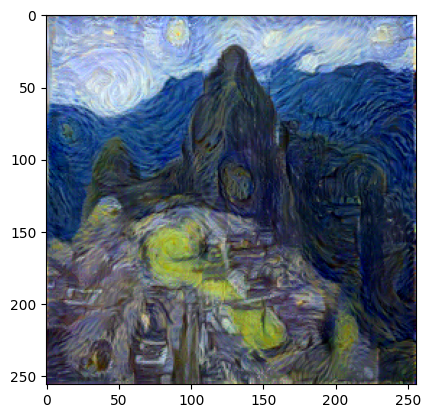

In [341]:
plt.imshow(img_final_test)

Machu Picchu estilo Van Gogh

# Observaciones importantes
* Es normal que el 'content loss' incremente su valor en cada época o iteración, ya que la imagen inicial que se quiere 'entrenar' es una 'copia' de la imagen de contenido. Así, la 'distancia' (loss) entre ambas (inicialmente) es cero.
Esto ocasionará que en las épocas posteriores el 'content loss' incremente, ya que luego de cada 'paso', el 'estilo' es añadido a la imagen inicial (la imagen que se quiere entrenar), diferenciándola de la imagen de contenido y generando que el loss content de la imagen inicial incremente.

* Así, si la imagen inicial hubiese sido 'ruido' al inicio, el loss content sería diferente desde las primeras iteraciones.